# Manipulating GUNW products using GDAL (python and commandline)

**Author**: Emre Havazli, David Bekaert - Jet Propulsion Laboratory

This notebook contains python and command line examples on how to use GDAL to manipulate the ARIA Geocoded UNWrapped interferogram (**GUNW**) products. Here we will use a GUNW product covering the north-eastern border between the United States and Canada over Lake Erie to illustrate operations such as:
- opening a GUNW product and reading its metadata                (Python/command line)
- accessing of datasets such as unwrapped phase                  (Python/command line)
- reading of a dataset into an array and plotting it on a map    (Python)
- cropping of a dataset to a user-defined boundary               (Python/command line)
- creating a KMZ file                                            (Python/command line)


<div class="alert alert-danger">
<b>Both the initial setup and download of the data should be run at the start of the notebook. However, the numbered sections do not need to be run in numerical order. </b>
</div>

<div class="alert alert-danger">
<b>Potential Error:</b> 
If the driver is not captured as "netCDF/Network Common Data Format" verify GDAL version is at least 2.5.
</div>

## Prep A. Initial setup of the notebook

Below we set-up the directory structure for this notebook excersice. In addition, we load the required modules into our python environment using ***import*** command. We also explicit enable exceptions for GDAL as this allows us to capture GDAL errors.

In [69]:
import os,sys
from osgeo import gdal,osr
import numpy as np
import matplotlib.pyplot as plt

# Enable GDAL/OGR exceptions
gdal.UseExceptions()

## Defining the home and data directories at the processing location
home_dir = os.getcwd()
tutorial_home_dir = os.path.abspath(os.path.join(home_dir, ""))
data_dir = os.path.join(tutorial_home_dir,'data')
print("home directory: ", tutorial_home_dir)

# data file
fileNames = [os.path.join(data_dir,'S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc')]
fileName = fileNames[0]

# generate all the folders in case they do not exist yet
if not os.path.exists(tutorial_home_dir):
    os.makedirs(tutorial_home_dir)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
os.chdir(tutorial_home_dir)


home directory:  /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/GDAL_basics
/Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/GDAL_basics/data


##  Prep B. Tutorial input dataset and download

The GUNW products are packages as netCDF4 files and include both data and meta-data layers such as interferogram amplitude, filtered unwrapped phase, filtered coherence, connected components, perpendicular and parallel baselines, incidence, azimuth and look angles. A detailed overview of the ARIA GUNW product with respect to processing, formatting, sampling, and data layers can be found on the [ARIA website](https://aria.jpl.nasa.gov/node/97).

Products can be downloaded from the [ARIA-products page](https://aria-products.jpl.nasa.gov) and [ASF DAAC vertex page](https://vertex.daac.asf.alaska.edu) under beta products. If you know the product filename you can construct the download link by appending the filename to the following URL: **https://<i></i>grfn.asf.alaska.edu<i></i>/door/download/**

<img src="support_docs/region.png" alt="region" width="400">

For our dataset we are focusing on the ascending track 77 of Sentinel-1 with an interferogram generated between 20190222 and 20190210. Our GUNW product ("S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc") covers the north-eastern border between the United States and Canada over Lake Erie. Given that we already know the product filename we can download the product by constructing the download URL.

https://grfn.asf.alaska.edu/door/download/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc

In [ ]:
# the GUNW products used in this demo

for file in fileNames:
    filename = os.path.basename(file)
    
    # if not os.path.isfile(os.path.join(data_dir,filename)):
    !ariaDownload.py --bbox "40.5 42.75 -82 -78" --start 20190210 --end 20190222  --workdir data_dir -v 
#     else:
#         print(filename + " already exists")
    os.chdir(tutorial_home_dir)

https://api.daac.asf.alaska.edu/services/search/param?asfplatform=Sentinel-1%20Interferogram%20(BETA)&output=JSON&bbox=-82,40.5,-78,42.75


## 1. Retrieving information on the product content

In this section we demonstrate how to retrieve an overview of all product variables and how they are structured within the product. We distinct between GDAL python and command line options.

### 1.1. GDAL PYTHON

First we will open the product using **gdal.Open()** by providing the filename including the location of of the product under consideration.

In [4]:
##Open netCDF file using GDAL##
ds = gdal.Open(fileName)

Now that the file is opened we can use **gdal.Info()** to retrieve information on the content including the variables and their structure. Below we show how to read the metadata into a variable and then print it. Once this is done we use to close the file by setting the file pointer to *None*.

In [5]:
##Retrieve an overview of the file content##
dataInfo = gdal.Info(ds)
# printing the information to the screen
print(dataInfo)
# closing the product
ds = None

Driver: netCDF/Network Common Data Format
Files: /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/GDAL_basics/data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc
Size is 512, 512
Metadata:
  NC_GLOBAL#author=David Bekaert
  NC_GLOBAL#Conventions=CF-1.6
  NC_GLOBAL#institution=Jet Propulsion Laboratory
  NC_GLOBAL#ogr_geometry_field=productBoundingBox
  NC_GLOBAL#ogr_layer_name=productBoundingBox
  NC_GLOBAL#ogr_layer_type=POLYGON
  NC_GLOBAL#product_type=UNW GEO IFG
  NC_GLOBAL#references=https://aria.jpl.nasa.gov/
  NC_GLOBAL#source=Contains modified Copernicus Sentinel data processed by ESA and ARIA NASA/JPL
  NC_GLOBAL#title=ARIA standard product UNW GEO IFG
  NC_GLOBAL#version=1b
Subdatasets:
  SUBDATASET_1_NAME=NETCDF:"/Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/GDAL_basics/data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc":productBoundingBox
  SUBDATASET_1_DESC=[1x464] productBoundingBox (8-bit c

### 1.2. GDAL command line

On the commandline **gdalinfo** can be used to retrieve an overview the product.

In [6]:
!gdalinfo ./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc

Driver: netCDF/Network Common Data Format
Files: ./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc
Size is 512, 512
Metadata:
  NC_GLOBAL#author=David Bekaert
  NC_GLOBAL#Conventions=CF-1.6
  NC_GLOBAL#institution=Jet Propulsion Laboratory
  NC_GLOBAL#ogr_geometry_field=productBoundingBox
  NC_GLOBAL#ogr_layer_name=productBoundingBox
  NC_GLOBAL#ogr_layer_type=POLYGON
  NC_GLOBAL#product_type=UNW GEO IFG
  NC_GLOBAL#references=https://aria.jpl.nasa.gov/
  NC_GLOBAL#source=Contains modified Copernicus Sentinel data processed by ESA and ARIA NASA/JPL
  NC_GLOBAL#title=ARIA standard product UNW GEO IFG
  NC_GLOBAL#version=1b
Subdatasets:
  SUBDATASET_1_NAME=NETCDF:"./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc":productBoundingBox
  SUBDATASET_1_DESC=[1x464] productBoundingBox (8-bit character)
  SUBDATASET_2_NAME=NETCDF:"./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc":/science/g

### 1.3. Interpretation

From the output you can see that the **netCDF driver** is used by GDAL to open the GUNW product. First, global variables are reported, followed by the sub-datasets. The latter includes 2D rasters such as the unwrapped phase and amplitude, as well as 3D data cubes such as the baseline and incidence angle. From the structure you can see that the 2D data is contained within the *"data"* folder while the 3D data is contained within an *"imagingGeometry"* folder. Note that GDAL does not report non-raster sub-datasets such as those included within the *"radarMetaData"* folder. 


Note that the top-level reported coordinates are not representable of individual data layers. The meta-data including projection, transformation and no-data values are available when querying for the specific sub-dataset as demonstrated in section 2.

## 2. Accessing to sub-datasets and statistics

In this section we demonstrate how to retrieve an overview for a product variable, also referred to as a sub-dataset. We distinct between GDAL python and command line options.

### 2.1. GDAL PYTHON

#### Accessing sub-datasets

We can access to subdatasets, such as unwrapped phase, and their metadata the same way we accessed the products. We need to open the specific subdataset, which we can do using their location in the file as outputed using method outlined in section 1.

In [10]:
##Open and retrieve information of the unwrapped phase##
unwPhase = gdal.Open("NETCDF:"+fileName+":/science/grids/data/unwrappedPhase")
# retrieve the information for the variable
unwPhaseInfo = gdal.Info(unwPhase)
# print the information to the screen
print(unwPhaseInfo)

Driver: netCDF/Network Common Data Format
Files: /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/GDAL_basics/data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc
       /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/GDAL_basics/data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc.aux.xml
Size is 4232, 2246
Coordinate System is:
GEOGCRS["unknown",
    DATUM["unnamed",
        ELLIPSOID["Spheroid",6378137,298.257223563,
            LENGTHUNIT["metre",1,
                ID["EPSG",9001]]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433,
            ID["EPSG",9122]]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]]
Data axis to CRS axis ma

#### Sub-dataset statistics

GDAL has functionality which allows to quickly calculate basic statistical properties of the data which accounting for no-data values. First we will retrieve the RasterBand of the unwrapped phase after which we will use the **GetStatistics()** functionality to compute the min, max, mean and standard deviation.

In [11]:
stats = unwPhase.GetRasterBand(1).GetStatistics(0,1)
# print to the screen
print('Min: ', stats[0])
print('Max: ', stats[1])
print('Mean: ', stats[2])
print('Standard Dev.: ', stats[3])
# close the file
unwPhase = None

Min:  -35.408046722412
Max:  20.177978515625
Mean:  -6.7323266167189
Standard Dev.:  4.2689717955368


### 2.2. GDAL command line

#### Accessing sub-datasets

Similar as to retrieve product information, **gdalinfo** can be used to retrieve an overview of a variable or sub-dataset by specifying directly the path sub-data variable. In case you do not know the path do a **gdalinfo** on the GUNW product as described in section 1.

In [12]:
!gdalinfo NETCDF:"./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc":/science/grids/data/unwrappedPhase

Driver: netCDF/Network Common Data Format
Files: ./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc
       ./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc.aux.xml
Size is 4232, 2246
Coordinate System is:
GEOGCRS["unknown",
    DATUM["unnamed",
        ELLIPSOID["Spheroid",6378137,298.257223563,
            LENGTHUNIT["metre",1,
                ID["EPSG",9001]]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433,
            ID["EPSG",9122]]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]]
Data axis to CRS axis mapping: 2,1
Origin = (-81.866250000000022,42.667083333333366)
Pixel Size = (0.000833333333333,-0.000833333333333)
Metadata:
  /science/

#### Sub-dataset statistics

The statistical properties of the data while accounting for the no-data value are available by appending **-stats** to the **gdalinfo** command line call.

In [13]:
!gdalinfo NETCDF:"./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc":/science/grids/data/unwrappedPhase -stats

Driver: netCDF/Network Common Data Format
Files: ./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc
       ./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc.aux.xml
Size is 4232, 2246
Coordinate System is:
GEOGCRS["unknown",
    DATUM["unnamed",
        ELLIPSOID["Spheroid",6378137,298.257223563,
            LENGTHUNIT["metre",1,
                ID["EPSG",9001]]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433,
            ID["EPSG",9122]]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]]
Data axis to CRS axis mapping: 2,1
Origin = (-81.866250000000022,42.667083333333366)
Pixel Size = (0.000833333333333,-0.000833333333333)
Metadata:
  /science/

### 2.3. Interpretation

The corner coordinates are listed at the bottom, together with the specific meta-data such as the **NoData** value. After running the statistics option also, the minimum, maximum, mean, and standard deviation are reported. The no-data value is considered when computing these statistics. The **projection** information is reported at the top and read by GDAL from the **crs** variable which lists the EPSG code as 4326. Note that GDAL does not capture all the information automatically at the top. Complete projection information for any EPSG code can be retrieved using **gdalsrsinfo**.

In [14]:
!gdalsrsinfo "EPSG:4326"


PROJ.4 : +proj=longlat +datum=WGS84 +no_defs

OGC WKT2:2018 :
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["unknown"],
        AREA["World"],
        BBOX[-90,-180,90,180]],
    ID["EPSG",4326]]



## 3. Reading the sub-dataset into an array and generating a map plot

In this section we will load the a product variable, i.e. sub-dataset, into python and vidualize it on a map.

### 3.1 GDAL Python

#### Loading data

Reading data sets into python arrays enables us to take advantage of a large suite of Python functionality. Below, we demonstrate how to read the *unwrappedPhase* sub-dataset into a **Numpy** array and manipulate the data to plot the unwrapped phase on a map while masking out water and no-data values. 


First, we open the product and the *unwrappedPhase* sub-dataset (see section 2 on how to retrieve this path). Next, we read the data by calling the **GetRasterBand()** functionality for the first band. Note that the unwrapped phase is a 2D raster and thus only contains one band which is also reported when you query the information for the *unwrappedPhase* sub-dataset. Also higher dimensional datasets can be stored as a **NumPy** array as is for example needed when loading the 3D data-cubes contained in the *"imagingGeometry"* folder. 

In [67]:
##Open and retrieve information of the unwrapped phase##
unwPhase = gdal.Open("NETCDF:"+fileName+":/science/grids/data/unwrappedPhase")

# loading the unwrapped phase into a numpy array
unwData = unwPhase.GetRasterBand(1).ReadAsArray()

# show the size of the array
print("Succesfully loaded the 'unwrappedPhase' sub-dataset into a Numpy array with size:")
print(unwData.shape)

Succesfully loaded the 'unwrappedPhase' sub-dataset into a Numpy array with size:
(2246, 4232)


To plot the unwrapped phase on map, we need to extract the **"Projection"** and **"transformation"** information. GDAL stores the transformation information as a vector with respectively upper left x-coordinate, x-coordinate sampling, skew of the x-coordinate, upper left y-coordinate, y-coordinate sampling, and lastly y-coordinate skew. Based on the transformation we can construct the four corners of the data given the specific projection. 

In [68]:
##Get Projection##
projection = osr.SpatialReference()
projection.ImportFromWkt(unwPhase.GetProjectionRef())

##Get corner coordinates##
ulLon, Lonres, Lonskew, ulLat, Latskew, Latres  = unwPhase.GetGeoTransform()
lrLon = ulLon + (unwPhase.RasterXSize * Lonres)
lrLat = ulLat + (unwPhase.RasterYSize * Latres)

###Let's round corner coordinates to the same number of digits as given in previous cell###
ulLon = np.round(ulLon,7)
ulLat = np.round(ulLat,7)
lrLon = np.round(lrLon,7)
lrLat = np.round(lrLat,7)

###Corner coordinates calculated in this cell###
print('''
Corner Coordinates calculated in this cell: ''',
'''Upper Left: ''', (ulLon,  ulLat),
'''Lower Left: ''', (ulLon,  lrLat),
'''Upper Right: ''', (lrLon,  ulLat),
'''Lower Right: ''', (lrLon,  lrLat), sep='\n')


Corner Coordinates calculated in this cell: 
Upper Left: 
(-81.86625, 42.6670833)
Lower Left: 
(-81.86625, 40.7954167)
Upper Right: 
(-78.3395833, 42.6670833)
Lower Right: 
(-78.3395833, 40.7954167)
WESN -81.86625 -78.3395833 40.7954167 42.6670833


You can compare this with the corners as reported by **gdalinfo** for the unwrapped phase.

#### Masking of no-data values and water bodies

After getting the required coordinate information we will prepare the dataset for visualization. As InSAR only works over land we will mask out water. One can do this using an auxiliary water mask or alternatively one can use the connected component layer as provided with the data. The connected component 0 corresponds to area’s that are decorrelated such as water. Here we opt for using the connected component as a mask option. In addition, we will mask out regions with no-data values.

In [17]:
##Get No Data Value##
NDV = unwPhase.GetRasterBand(1).GetNoDataValue()
# closing the file 
unwPhase = None

## Loading the connected component.
connComp = gdal.Open("NETCDF:"+fileName+":/science/grids/data/connectedComponents")
connCompData = connComp.GetRasterBand(1).ReadAsArray()
connComp = None


##Masking out the no-data
unwDataMasked = np.ma.masked_array(unwData, mask=unwData==NDV, fill_value=999999)
##Masking out connected component 0, which typically correspond to decorrelated area's such as water
unwDataMasked = np.ma.masked_array(unwDataMasked, mask=connCompData==0, fill_value=999999)

#### Generating a map plot

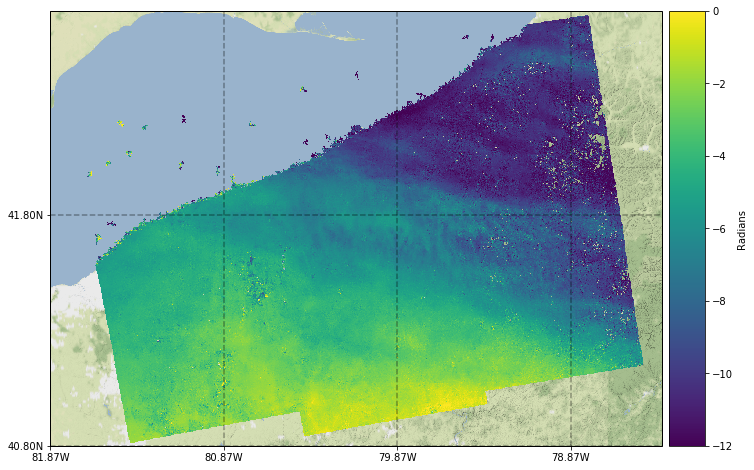

In [65]:
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

basemap   = cimgt.Stamen('terrain-background')
#######The plot extend is image corners###########
WESN      = [ulLon, lrLon, lrLat, ulLat]
fig, axes = plt.subplots(figsize=(20,8), subplot_kw={'projection':basemap.crs})
axes.set_extent(WESN, ccrs.Geodetic())
axes.add_image(basemap, 10)
axes.coastlines()
im = axes.imshow(unwDataMasked, cmap='viridis', vmin=-12, vmax=0, zorder=1, extent=WESN, origin = 'upper', transform=ccrs.PlateCarree())
cbar_ax   = fig.add_axes([0.730, 0.125, 0.025, 0.755])
fig.colorbar(im, cbar_ax, label='Radians', spacing='proportional')
axes.set_xticks(np.arange(WESN[0], WESN[1], 1), crs=ccrs.PlateCarree())
axes.set_yticks(np.arange(WESN[2], WESN[3], 1), crs=ccrs.PlateCarree())
axes.grid(linewidth=1.5, color='black', alpha=0.35, linestyle='--', zorder=2)
lon_formatter = LongitudeFormatter(number_format='.2f', degree_symbol='')
lat_formatter = LatitudeFormatter(number_format='.2f', degree_symbol='')
axes.xaxis.set_major_formatter(lon_formatter)
axes.yaxis.set_major_formatter(lat_formatter)
plt.show()

### 3.2. Interpretation

The generated figure shows the unwrapped phase. As InSAR does not maintain a signal over water we have masked it out using the connected component 0 as a proxy. You can see that the remaining land signal varies roughly up to 12 radians (~5.6 cm of line-of-sight displacement at C-band). Given the short span of the interferogram (12-days) these signals can be mostly attributed to atmospheric noise.

## 4. Cropping the data at given boundaries and creating KMZ files

In this section we are going to use gdal capability to export the data into a KMZ file which can be viewed in Google Earth.

### 4.1. GDAL PYTHON

#### Exporting the data as KMZ

KMZ file generation can be done using the **gdal.Translate()** function. First we will open the "unwrappedPhase" sub-dataset. The **gdal.Translate()** only needs the output name, input data (i.e. the opened sub-dataset) and the **translateOptions**. We define the options using gdal.ParseCommandLine() function which allows us to pass gdal_translate options in notebook environment. 

As options we specify the **-scale** and **-format**. Note that for format we are using *png* which has a valid data range of 0-256. The **-scale** option will automatically rescale our input data to the valid *png* range.

In [49]:
##Open and retrieve information of the unwrapped phase##
unwPhase = gdal.Open("NETCDF:"+fileName+":/science/grids/data/unwrappedPhase")

# translating the unwrapped phase to kmz
translateOptions = gdal.TranslateOptions(gdal.ParseCommandLine('-of KMLSUPEROVERLAY -scale -co format=png'))
kmzFile = gdal.Translate("unwrappedPhase.kmz", unwPhase, options=translateOptions)

# closing the original file
unwPhase = None

# summary and check if the file was generated
print("Done: ")
!ls unwrappedPhase.kmz

Done: 
unwrappedPhase.kmz


#### Cropping the data and exporting as KMZ

By only adding the **projwin** option into gdal.TranslateOptions we can crop the data and export the cropped plot into a KMZ file

In [50]:
##Open and retrieve information of the unwrapped phase##
unwPhase = gdal.Open("NETCDF:"+fileName+":/science/grids/data/unwrappedPhase")

translateOptions = gdal.TranslateOptions(gdal.ParseCommandLine('-of KMLSUPEROVERLAY -scale -co format=png -projwin -81.00 42.30 -80.00 41.50'))
kmzFileCrop = gdal.Translate("unwrappedPhaseCrop.kmz", unwPhase, options=translateOptions)

# closing the original file
unwPhase = None

# summary and check if the file was generated
print("Done: ")
!ls unwrappedPhaseCrop.kmz

Done: 
unwrappedPhaseCrop.kmz


### 4.2. GDAL command line

#### Exporting the data as KMZ

KMZ file generation can be done using the **gdal_translate** command by specifying **KMLSUPEROVERLAY** as output format in addition to the output name and input dataset to be used. In addition, we specify the **-scale** and **-format** options. Note that for format we are using *png* which has a valid data range of 0-256. The **-scale** option will automatically rescale our input data to the valid *png* range.

In [51]:
!gdal_translate  -of KMLSUPEROVERLAY -scale -co format=png "NETCDF:./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc:/science/grids/data/unwrappedPhase" unwrappedPhase.kmz
!ls unwrappedPhase.kmz

Input file size is 4232, 2246
0...10...20...30...40...50...60...70...80...90...100 - done.
unwrappedPhase.kmz


#### Cropping the data and exporting as KMZ

By only adding the **projwin** option to the **gdal_translate** options we can crop the data and export the cropped plot into a KMZ file.

In [52]:
!gdal_translate -of KMLSUPEROVERLAY -scale -co format=png -projwin -81.00 42.30 -80.00 41.50 "NETCDF:./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc:/science/grids/data/unwrappedPhase" unwrappedPhaseCrop.kmz
!ls unwrappedPhaseCrop.kmz

Input file size is 4232, 2246
0...10...20...30...40...50...60...70...80...90...100 - done.
unwrappedPhaseCrop.kmz


### 4.2. Interpretation

Below is the result when opening both the full and cropped products in **GoogleEarth**

<img src="support_docs/unwrappedPhase.png" alt="region" width="400">
<img src="support_docs/unwrappedPhaseCropped.png" alt="region" width="400">

